In [25]:
# Habilitar autoreload para que los cambios en los modulos se reflejen automaticamente
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

SEED = 42
np.random.seed(SEED)

# Obtener la ruta del directorio donde está el notebook
OS_CWD = os.getcwd()
BASE_DIR = os.path.dirname(OS_CWD)  # No cambiar el directorio de trabajo

# Construcción de rutas absolutas
DEV_PATH    = os.path.join(BASE_DIR, 'data', 'raw', 'casas_dev.csv')
TEST_PATH   = os.path.join(BASE_DIR, 'data', 'raw', 'casas_test.csv')
AMANDA_PATH = os.path.join(BASE_DIR, 'data', 'raw', 'vivienda_Amanda.csv')

TRAIN_OUTPUT = os.path.join(BASE_DIR, 'data', 'processed', 'train.csv')
VAL_OUTPUT   = os.path.join(BASE_DIR, 'data', 'processed', 'val.csv')
TEST_OUTPUT  = os.path.join(BASE_DIR, 'data', 'processed', 'test.csv')

import sys
sys.path.append(os.path.join(OS_CWD, '..', 'src'))

dev_df = pd.read_csv(DEV_PATH)
test_df = pd.read_csv(TEST_PATH)

# 1. Exploración de datos


## 1.1. Visualización de datos
Se puede decir que este dataset está “sucio” ya que pueden haber datos erróneos o faltantes. Imprima en pantalla un fragmento aleatorio del dataset e indique qué columnas sería útil modificar y de qué manera. Es útil explorar un resumen con los estadísticos básicos y les recordamos que pueden existir valores faltantes (expresados como NaNs).

In [27]:
dev_df.sample(n=10)

,area,area_units,is_house,has_pool,age,price,lat,lon,rooms
70,872.0,sqft,0,0,11.0,630.0,40.718433,-74.008699,2.0
827,1076.0,sqft,0,0,7.0,772.0,40.707037,-73.998823,3.0
231,137.0,m2,0,0,10.0,214.0,-34.550223,-58.391268,4.0
588,775.0,sqft,1,1,10.0,751.0,40.726223,-74.043929,2.0
39,154.0,m2,1,0,16.0,273.0,-34.563525,-58.347365,4.0
731,710.0,sqft,0,0,7.0,493.0,40.706159,-74.021740,2.0
299,128.0,m2,0,0,9.0,247.0,-34.608909,-58.392922,NaN
110,1399.0,sqft,0,0,11.0,948.0,40.722493,-73.977268,4.0
72,103.0,m2,1,0,15.0,190.0,-34.573679,-58.460096,3.0
86,47.0,m2,1,0,12.0,93.0,-34.640750,-58.430882,1.0


In [28]:
from utils import analyze_null_values, show_unique_values, analyze_dataframe_size
analyze_null_values(dev_df)
show_unique_values(dev_df)
analyze_dataframe_size(dev_df)

Number of rows with at least one null value: 189

Number of null values per column and their percentage:


|            |   Null Count |   Percentage |
|:-----------|-------------:|-------------:|
| age        |          130 |        14.44 |
| rooms      |           72 |         8    |
| area       |            0 |         0    |
| is_house   |            0 |         0    |
| area_units |            0 |         0    |
| has_pool   |            0 |         0    |
| price      |            0 |         0    |
| lat        |            0 |         0    |
| lon        |            0 |         0    |


Unique values for columns that are not of type float:
area_units: ['sqft' 'm2']
is_house: [1 0]
has_pool: [0 1]
Original DataFrame length: 900
DataFrame length without null values: 711
Percentage difference after removing nulls: 21.00%


A partir de los resultados obtenidos, podemos notar que las columnas **'age'** y **'rooms'** contienen valores nulos. Además, observamos que la columna **'area'** presenta dos unidades distintas: **m²** y **sqft**.

La opción más conveniente sería convertir todas las medidas de **'sqft'** a **m²**, permitiendo trabajar con una única unidad de medida. No obstante, podríamos conservar la unidad original en una nueva columna en caso de que fuera necesario.

En cuanto a los valores nulos, existen dos posibles enfoques:
- **Eliminar las filas** que contienen valores nulos en las columnas **'age'** y **'rooms'**.
- **Completar los valores faltantes** utilizando la media de cada columna. Esta decisión se basaría en la suposición de que cada variable sigue una distribución normal, lo que haría de la media un buen estimador.

En este caso, se realizará la segunda opción, pero la misma se hará luego de la conversión de las unidades de medida y luego de la separación en los __dataframes__ test y train, para evitar el **data leakage**.

## 1.2. Distribución de variables
Realice una serie de histogramas y diagramas de dispersión (scatterplots) para mostrar
la relación entre las variables. Para esto, es útil el comando pairplot. ¿Qué conclusio-
nes puede extraer a simple vista acerca de las relaciones entre las variables? Se permite
la creación de gráficos adicionales que considere relevantes.

In [29]:
import os
from IPython.display import Image

# Esto es completamente innecesario, pero es para ahorrarme un poco de tiempo cuando tengo que correr todo el notebook.
plot_path = os.path.join(BASE_DIR, 'data', 'processed', 'plots', 'pairplot.png')
os.makedirs(os.path.dirname(plot_path), exist_ok=True)

def plot_pairplot(dev_df):
    if os.path.exists(plot_path):
        display(Image(filename=plot_path))
    else:
        sns.pairplot(dev_df)
        plt.savefig(plot_path)
        plt.show()

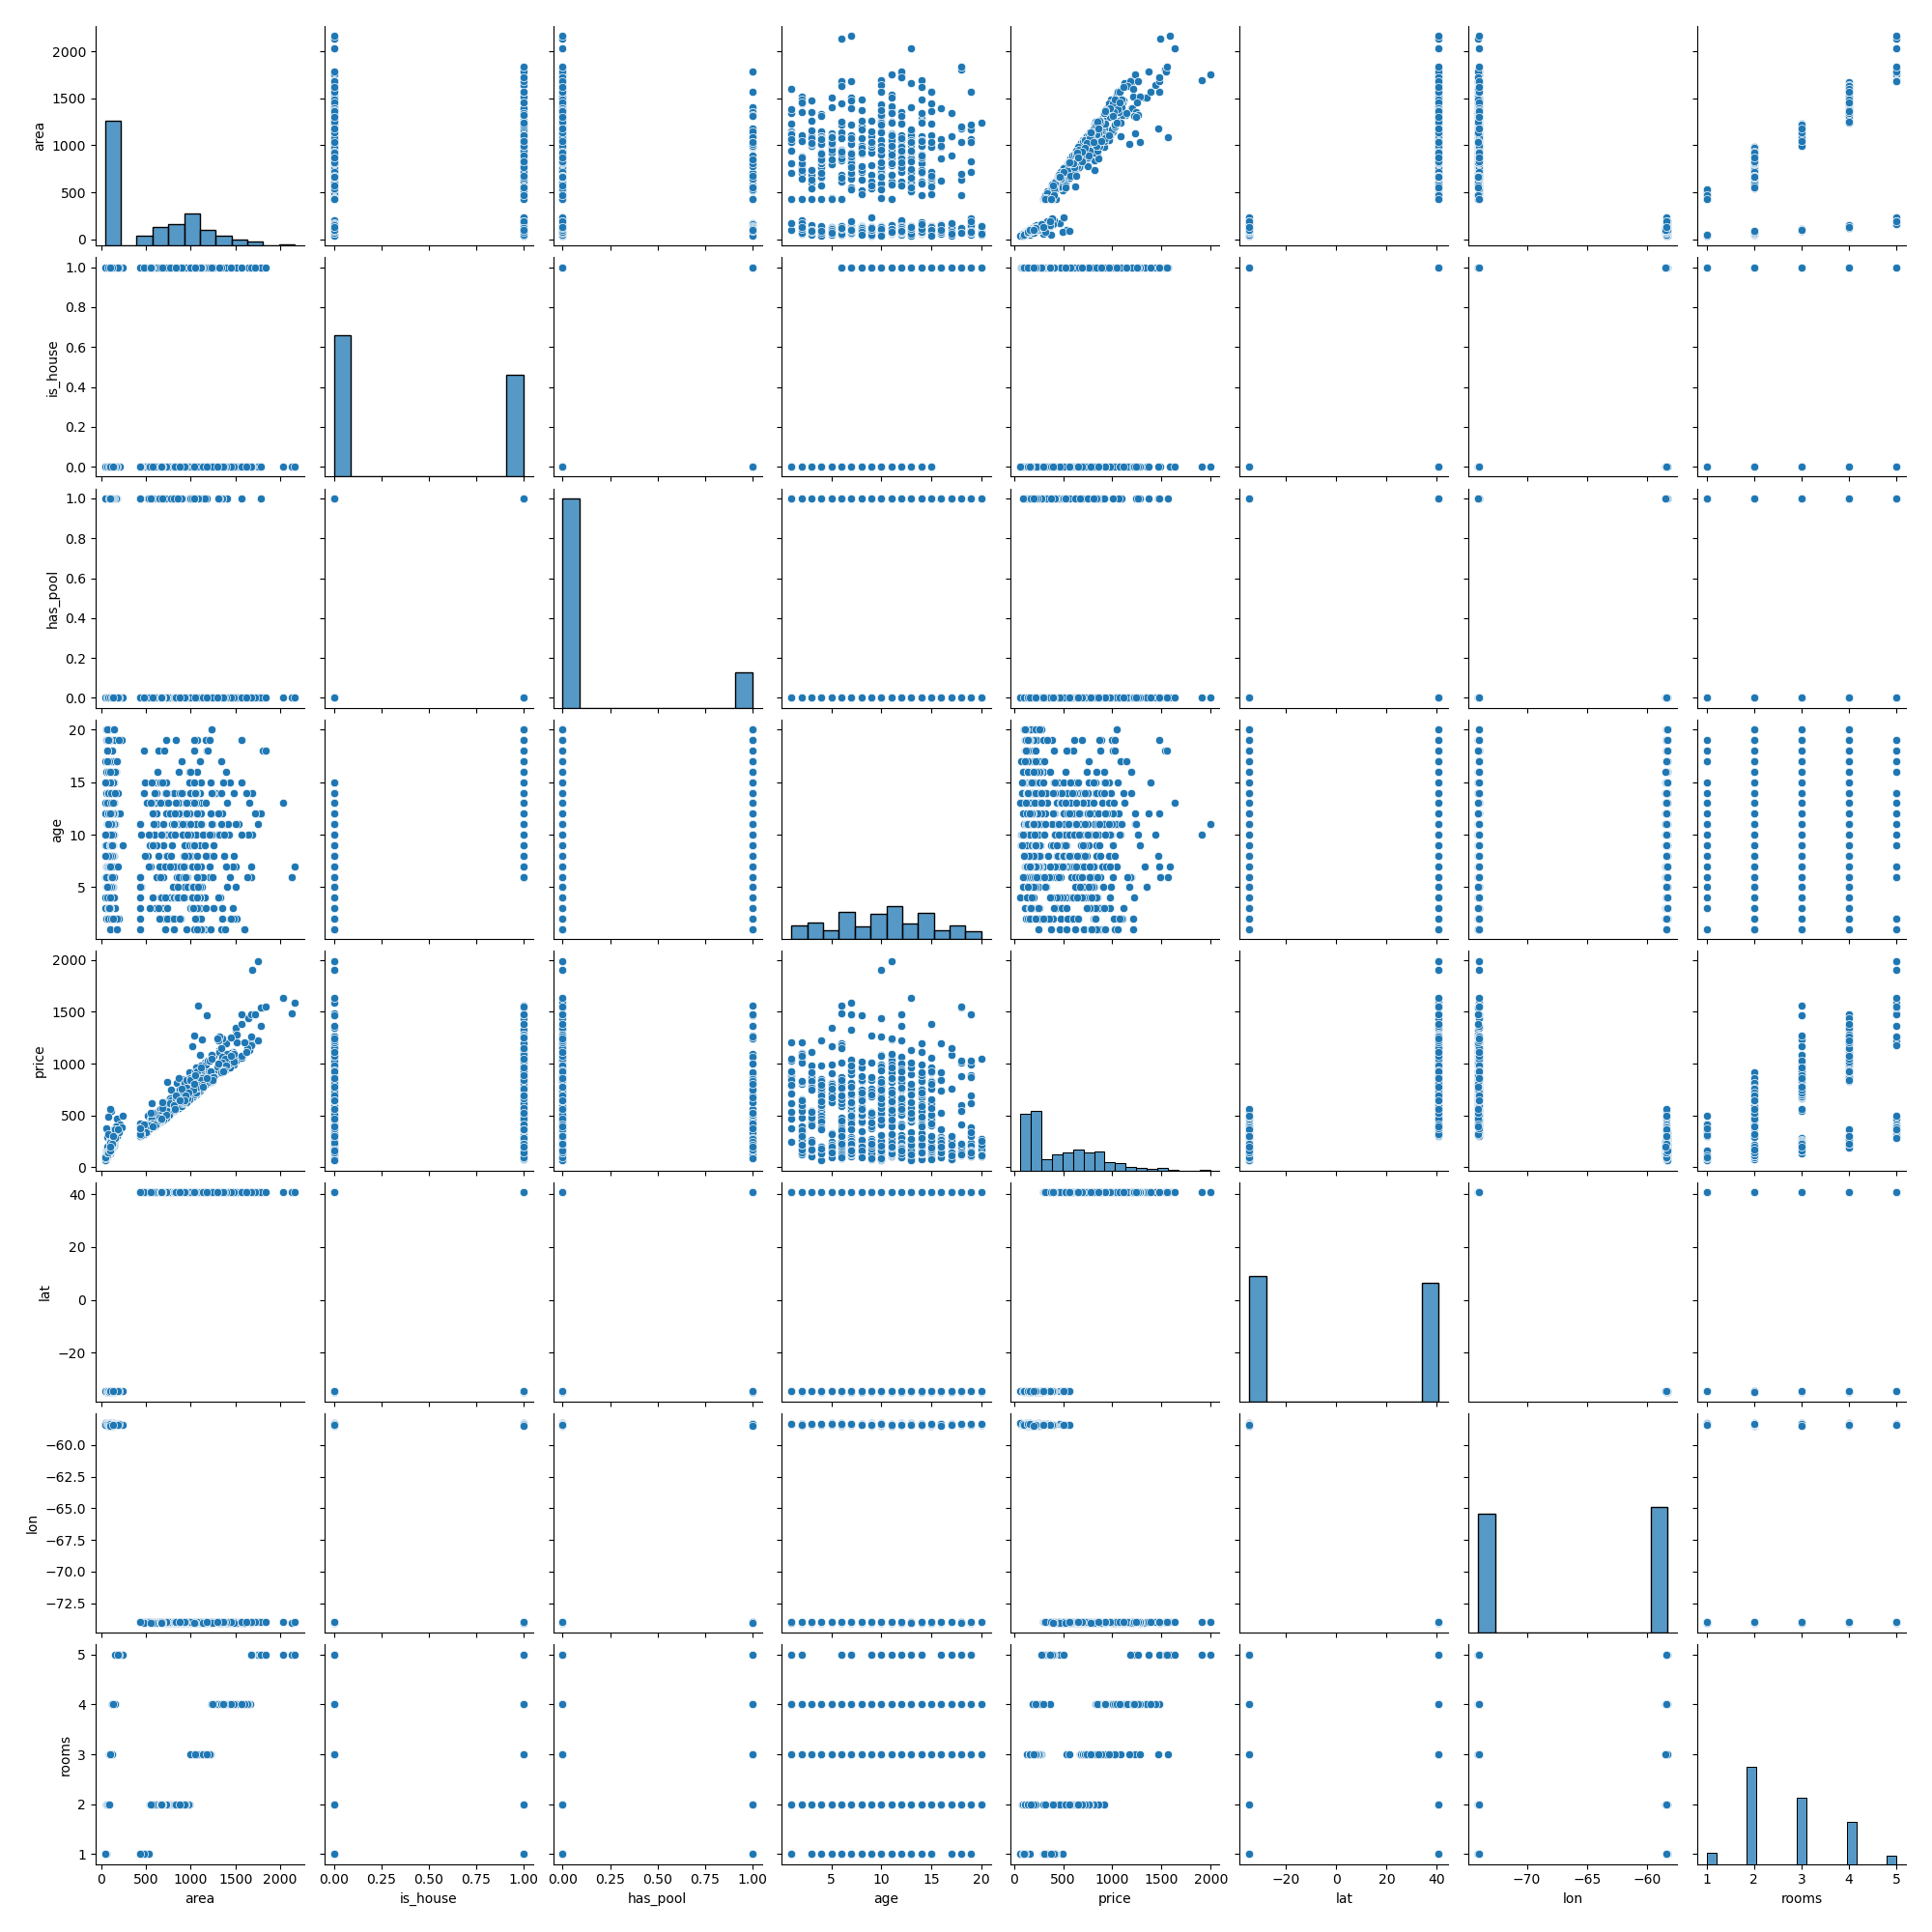

In [30]:
plot_pairplot(dev_df)

### Análisis de los Histogramas y Diagramas de Dispersión

1. **Distribución de las variables:**
   - En la diagonal del *pairplot*, observamos los histogramas de cada variable.
   - En términos generales, muchas de las distribuciones que no son del tipo Bernulli se aproximan a una forma de **campana de Gauss**, validando en cierta medida nuestra suposición de que podrían seguir una distribución normal.
   - Sin embargo, la variable **'rooms'** no presenta una forma tan claramente gaussiana. Esto puede deberse a la naturaleza discreta de los datos (cantidad de habitaciones), lo que genera una distribución más sesgada o con valores discretos.

2. **Relación entre las variables:**  
   - Se observa una fuerte relación **lineal** entre **'area'** y **'rooms'**, lo cual es esperable, ya que a mayor área, es probable que la propiedad tenga más habitaciones.  
   - Además, se percibe una posible correlación positiva entre **'price'** y **'area'**, así como entre **'price'** y **'rooms'**, lo que sugiere que tanto el tamaño de la propiedad como la cantidad de habitaciones pueden influir en el precio.  
   - Existen algunas otras relaciones más dispersas entre variables, pero no parecen evidenciar patrones claros a simple vista.  

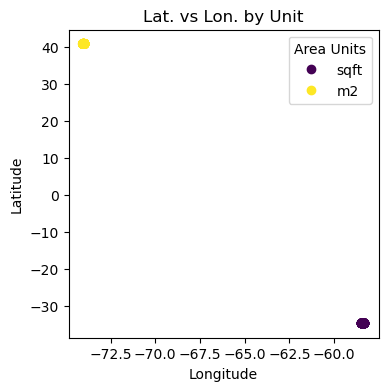

                  lat                  lon          
                 mean       std       mean       std
area_units                                          
m2         -34.601978  0.037119 -58.380370  0.037650
sqft        40.710111  0.021398 -74.005426  0.022423


In [31]:
from plotting import plot_lat_lon
print(plot_lat_lon(dev_df))

#### Diferenciación de unidades según ubicación  

Este gráfico muestra cómo las casas medidas en *sqft* y en *m²* se agrupan en distintas ubicaciones geográficas.  

- Las viviendas con área en *m²* están ubicadas en **latitud -34.601978** y **longitud -58.380370**.
- Las viviendas con área en *sqft* se encuentran en **latitud 40.710111** y **longitud -74.005426**. 

Esto pareciera indicar que existen dos grupos de datos distintos, lo que nos indica que, si bien queremos conservar las mismas unidades de medida, deberíamos considerar la posibilidad de indicarle al modelo que existen dos grupos de datos distintos.

Esto se realizará realizando el encoding de la columa **'area_unit'**, que indicará si la propiedad está medida en *m²* o en *sqft* con un valor binario. La nueva columna se llamará **'north'** y tomará el valor 1 si la propiedad está ubicada en el norte y 0 si está ubicada en el sur.

## 1.3 Separación de datos
Divida el conjunto de desarrollo casas_dev.csv en un 80 % para entrenamiento (train)
y un 20 % para validación (validation). Estos conjuntos se utilizarán para entrenar y
validar los modelos que desarrollarán en las siguientes secciones. Se sugiere normalizar
los datos para lograr un mejora el condicionamiento numérico de los algortmos de
aprendizaje. Recuerde que si normaliza los datos, cuando haga una predicción deberá
invertir la normalización para volver a las escalas originales.

In [32]:
from preprocessing import normalize_df, fill_na
from utils import pretty_print_df
from data_splitting import train_val_split
train_df, val_df = train_val_split(dev_df, 0.2, SEED)

print(f"Sample of the non-normalized train dataframe:")
pretty_print_df(train_df.head(5))

columns_df = ["area", "age", "lat", "lon", "rooms"]
method_df = 'gaussian'

normalized_train_df, denormalize_train = normalize_df(train_df, method=method_df, columns=columns_df, normalize=True)
normalized_val_df, denormalize_val = normalize_df(val_df, method=method_df, columns=columns_df, normalize=True)

columns_to_fill = ['age', 'rooms']
train_df = fill_na(normalized_train_df, columns_to_fill)
val_df = fill_na(normalized_val_df, columns_to_fill)

print(f"Sample of the normalized train dataframe:")
pretty_print_df(normalized_train_df.head(5))

# Save the train and val dataframes
train_df.to_csv(TRAIN_OUTPUT, index=False)
val_df.to_csv(VAL_OUTPUT, index=False)

# Save the denormalization dictionary
import json
with open(os.path.join(BASE_DIR, 'data', 'processed', 'denormalize_train.json'), 'w') as f:
    json.dump(denormalize_train, f, indent=4)
    
with open(os.path.join(BASE_DIR, 'data', 'processed', 'denormalize_val.json'), 'w') as f:
    json.dump(denormalize_val, f, indent=4)

Sample of the non-normalized train dataframe:


|   Area | Area Units   |   Is House |   Has Pool |   Age |   Price |      Lat |      Lon |   Rooms |
|-------:|:-------------|-----------:|-----------:|------:|--------:|---------:|---------:|--------:|
|    635 | sqft         |          1 |          0 |    18 |     546 |  40.6791 | -74.0078 |       2 |
|   1098 | sqft         |          0 |          0 |     9 |     759 |  40.7128 | -73.9678 |       3 |
|    667 | sqft         |          0 |          0 |     7 |     464 |  40.6699 | -74.0294 |       2 |
|    127 | m2           |          1 |          1 |    16 |     251 | -34.6004 | -58.4153 |       4 |
|   1378 | sqft         |          0 |          0 |     8 |     963 |  40.7223 | -73.9832 |       4 |

Sample of the normalized train dataframe:


|      Area |   Is House |   Has Pool |       Age |   Price |      Lat |       Lon |     Rooms |   North |
|----------:|-----------:|-----------:|----------:|--------:|---------:|----------:|----------:|--------:|
| -1.17426  |          1 |          0 |  1.6078   |     546 |  1.02948 | -1.03064  | -0.750834 |       1 |
|  0.245111 |          0 |          0 | -0.261859 |     759 |  1.03038 | -1.02551  |  0.28842  |       1 |
| -1.07616  |          0 |          0 | -0.677339 |     464 |  1.02924 | -1.0334   | -0.750834 |       1 |
|  1.06981  |          1 |          1 |  1.19232  |     251 | -0.96913 |  0.964645 |  1.32767  |       0 |
|  1.10348  |          0 |          0 | -0.469599 |     963 |  1.03063 | -1.02749  |  1.32767  |       1 |

El conjunto de datos `casas_dev.csv` se dividió en:
- **80%** para entrenamiento (train)
- **20%** para validación (validation)

#### Observaciones:
1. **Conversión de Unidades**:  
   - La conversión entre `sqft` y `m2` se realizó **antes** de dividir el dataset, ya que cada transformación se hizo únicamente sobre los valores de su propia fila sin depender de datos externos, evitando así el **data leakage**.
   - Se creó una nueva columna llamada `north` que toma el valor 1 si la propiedad está ubicada en el norte y 0 si está ubicada en el sur.
   
2. **Normalización Gaussiana**:  
   - Se aplicó **normalización gaussiana** a las variables continuas con la transformación:  
    $X' = \frac{X - \mu}{\sigma}$
    - Se guardaron los valores de $\mu$ y $\sigma$ para cada variable continua, con el fin de poder invertir la normalización en el futuro.

3. **Variables normalizadas y excluidas**:  
   - **Se normalizaron:** `Age`, `Lat`, `Lon`, `Rooms` y `Area`.  
   - **Se excluyeron de la normalización:**  
     - Variables binarias.
     - La variable `Price`.


# Sección 2

### 2.1 Implementación de una Clase de Regresión Lineal

#### Descripción

Se debe implementar una clase de regresión lineal en Python. El constructor de la clase deberá recibir `X` e `y`, y se deberán incluir dos métodos de entrenamiento:

1. **Entrenamiento mediante la pseudo-inversa**
2. **Entrenamiento mediante descenso por gradiente**  

En ambos casos, los coeficientes (pesos) resultantes de la regresión deben almacenarse en el atributo `self.coef`.

#### Nota
Se debe incluir un método que permita imprimir los coeficientes junto con los nombres de sus respectivas variables de forma prolija.

---

### 2.2 Implementación de la Función de Pérdida

Se debe implementar la **función de pérdida** utilizando el **Error Cuadrático Medio (ECM)**, definida como:

$ECM = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

Donde:
- $( y_i )$ es el valor real de la variable objetivo.
- $( \hat{y}_i )$ es la predicción generada por el modelo.
- $( n )$ es el número total de muestras.

---

### 2.3 Verificación de la Implementación

Se debe verificar que la implementación de la regresión lineal funcione correctamente en los siguientes casos:

1. Cuando se tiene **una sola característica** (una variable independiente en `X`).
2. Cuando se tienen **múltiples características** (varias variables independientes en `X`).

Para esto, se recomienda probar el modelo con conjuntos de datos de prueba, evaluar los coeficientes obtenidos y calcular el **Error Cuadrático Medio (ECM)** para medir la calidad de la predicción.


In [33]:
from utils import trainPredictAndImport
print('========================================================')
print('Results using only one feature (area) and both methods')
trainPredictAndImport(train_df, val_df, feature='area', method='both')

Results using only one feature (area) and both methods
Results for Gradient Descent
Model trained with 1000 epochs and learning rate of 0.01.
Model's performance:
MSE: 103,337.523495, MAE: 295.188514, RMSE: 321.461543, R2: 0.153027


|   Intercept |    Area |
|------------:|--------:|
|     465.942 | 136.729 |

Switching to validation data
Model's loss:
MSE: 105,608.692264, MAE: 298.565702, RMSE: 324.974910, R2: 0.071725
Results for Pseudo Inverse
Model trained using the pseudo-inverse method.
Model's performance:
MSE: 103,337.523054, MAE: 295.189346, RMSE: 321.461542, R2: 0.153027


|   Intercept |    Area |
|------------:|--------:|
|     465.963 | 136.735 |

Switching to validation data
Model's loss:
MSE: 105,609.101204, MAE: 298.566661, RMSE: 324.975539, R2: 0.071721


In [34]:
print('========================================================')
print('Results using all features and both methods')
trainPredictAndImport(train_df, val_df, feature='all', method='both')

Results using all features and both methods
Results for Gradient Descent
Model trained with 1000 epochs and learning rate of 0.01.
Model's performance:
MSE: 15,488.474118, MAE: 89.038139, RMSE: 124.452698, R2: 0.873054


|   Intercept |    Area |   Is House |   Has Pool |      Age |     Lat |      Lon |   Rooms |   North |
|------------:|--------:|-----------:|-----------:|---------:|--------:|---------:|--------:|--------:|
|     322.814 | 126.355 |    88.8374 |    25.9765 | -13.5282 | 104.677 | -104.621 | 27.8996 | 208.816 |

Switching to validation data
Model's loss:
MSE: 15,405.801598, MAE: 87.533704, RMSE: 124.120110, R2: 0.864587
Results for Pseudo Inverse
Model trained using the pseudo-inverse method.
Model's performance:
MSE: 15,217.021509, MAE: 87.988223, RMSE: 123.357292, R2: 0.875279


|   Intercept |    Area |   Is House |   Has Pool |      Age |     Lat |     Lon |    Rooms |    North |
|------------:|--------:|-----------:|-----------:|---------:|--------:|--------:|---------:|---------:|
|     2642.05 | 162.096 |    74.1554 |    19.7061 | -9.13552 | 2841.46 | 249.244 | -9.06423 | -4559.64 |

Switching to validation data
Model's loss:
MSE: 16,662.511495, MAE: 87.111564, RMSE: 129.083351, R2: 0.853541


# Sección 3

### 3.1 Regresión Lineal Simple
Se debe realizar una regresión lineal simple para predecir el **precio** de una propiedad utilizando como única variable explicativa el **área**.

In [35]:
trainPredictAndImport(train_df, val_df, feature='area', method='both')

Results for Gradient Descent
Model trained with 1000 epochs and learning rate of 0.01.
Model's performance:
MSE: 103,337.523495, MAE: 295.188514, RMSE: 321.461543, R2: 0.153027


|   Intercept |    Area |
|------------:|--------:|
|     465.942 | 136.729 |

Switching to validation data
Model's loss:
MSE: 105,608.692264, MAE: 298.565702, RMSE: 324.974910, R2: 0.071725
Results for Pseudo Inverse
Model trained using the pseudo-inverse method.
Model's performance:
MSE: 103,337.523054, MAE: 295.189346, RMSE: 321.461542, R2: 0.153027


|   Intercept |    Area |
|------------:|--------:|
|     465.963 | 136.735 |

Switching to validation data
Model's loss:
MSE: 105,609.101204, MAE: 298.566661, RMSE: 324.975539, R2: 0.071721


### 3.2 Modelo de Regresión Múltiple
Se debe desarrollar un modelo de **regresión lineal múltiple** que prediga el precio en función de las características más relevantes del dataset.  

#### Tarea
- Entrenar el modelo con las características seleccionadas.
- Utilizar el modelo entrenado para predecir el precio de las propiedades en el archivo `vivienda_Amanda.csv`.

In [36]:
amanda_df = pd.read_csv(AMANDA_PATH)
print("DataFrame before normalization")
pretty_print_df(amanda_df)

amanda_cols = amanda_df.columns
normalized_amanda_df, _ = normalize_df(amanda_df, method=method_df, columns=amanda_cols, normalize=True, normalize_dict=denormalize_train)

print("\nDataFrame after normalization")
pretty_print_df(normalized_amanda_df)

from models import LinearRegression
X = train_df.drop(columns=['price'])
y = train_df['price']

model = LinearRegression(X, y)
model.fit_pseudo_inverse()
prediction = model.predict(normalized_amanda_df)

print(f"\nPredicted price with Pseudo Inverse: ${prediction:.2f}\n")

print("========================================================")

model = LinearRegression(X, y)
model.fit_gradient_descent()
prediction = model.predict(normalized_amanda_df)

print(f"Predicted price with Gradient Descent: ${prediction:.2f}")


DataFrame before normalization


|   Area | Area Units   |   Is House |   Has Pool |   Age |     Lat |     Lon |   Rooms |
|-------:|:-------------|-----------:|-----------:|------:|--------:|--------:|--------:|
|   1119 | sqft         |          0 |          0 |    11 | 40.6754 | -74.013 |       3 |


DataFrame after normalization


|     Area |   Is House |   Has Pool |     Age |     Lat |     Lon |   Rooms |   North |
|---------:|-----------:|-----------:|--------:|--------:|--------:|--------:|--------:|
| 0.309488 |          0 |          0 | 0.15362 | 1.02939 | -1.0313 | 0.28842 |       1 |

Model trained using the pseudo-inverse method.
Model's performance:
MSE: 15,217.021509, MAE: 87.988223, RMSE: 123.357292, R2: 0.875279

Predicted price with Pseudo Inverse: $796.47

Model trained with 1000 epochs and learning rate of 0.01.
Model's performance:
MSE: 15,488.474118, MAE: 89.038139, RMSE: 124.452698, R2: 0.873054
Predicted price with Gradient Descent: $792.35


### 3.3 Valor Promedio por Metro Cuadrado

#### Cálculo
Se debe calcular el **valor promedio por metro cuadrado** de una casa dentro del dataset, definido como:

$\text{Valor Promedio} = \frac{\sum \text{Precio}}{\sum \text{Área}}$

Donde:
- $\sum \text{Precio}$ es la suma total de los precios de las propiedades.
- $\sum \text{Área}$ es la suma total de los metros cuadrados de todas las propiedades.

In [37]:
avg_price_df, _ = normalize_df(dev_df[dev_df['is_house'] == 1], normalize=False)
avg_price_data = avg_price_df['price'] / avg_price_df['area']
avg_price_mean = (avg_price_data).mean()
avg_price_std = (avg_price_data).std()
print(f"Average price per square meter: ${avg_price_mean:.2f} ± ${avg_price_std:.2f}")


Average price per square meter: $3.58 ± $3.14


Como podemos observar, obtenemos un resultado de **$3.58 USD/m²**, pero con una desviación estándar de **± $3.14 USD/m²**, lo que indica una alta dispersión en los datos. Esta variabilidad sugiere que el valor promedio no es representativo de un solo grupo homogéneo de propiedades.

### Separación por Clusters según Mercado

Dado que en los análisis previos de **precio vs área** se observó que las propiedades cuyo tamaño fue originalmente reportado en **pies cuadrados** tienden a ser significativamente más caras que aquellas reportadas en **metros cuadrados**, se realizará una separación en dos clusters:

1. **Propiedades originalmente medidas en metros cuadrados (m²)**  
2. **Propiedades originalmente medidas en pies cuadrados (sqft)**, pero convertidas a m² para el análisis

Esta segmentación permitirá analizar las diferencias entre ambos mercados, ya que la alta variabilidad sugiere que pertenecen a contextos distintos. Mantendremos todas las propiedades en **metros cuadrados** para uniformidad en el análisis, pero sin mezclar directamente ambos grupos, evitando que las diferencias de mercado distorsionen los resultados.

Nota: 
Se utilizó USD como unidad de precio sin criterio alguno, ya que no se especifica la moneda en el dataset y no se cuenta con información adicional.


In [38]:
def calculate_avg_price_per_m2(df):
    """
    Calcula el precio promedio por metro cuadrado y su desviación estándar.
    
    Args:
        df (DataFrame): DataFrame con las columnas 'price' y 'area'.
    
    Returns:
        tuple: (promedio, desviación estándar) del precio por metro cuadrado.
    """
    avg_price_per_m2 = df['price'] / df['area']
    return avg_price_per_m2.mean(), avg_price_per_m2.std()

In [39]:
# Filtrar datos por región
north_df = avg_price_df[avg_price_df['north'] == 1]
south_df = avg_price_df[avg_price_df['north'] == 0]

# Calcular estadísticas
north_avg_price_mean, north_avg_price_std = calculate_avg_price_per_m2(north_df)
south_avg_price_mean, south_avg_price_std = calculate_avg_price_per_m2(south_df)

# Imprimir resultados
print(f"Average price per square meter in the North: ${north_avg_price_mean:.2f} ± ${north_avg_price_std:.2f}")
print(f"Average price per square meter in the South: ${south_avg_price_mean:.2f} ± ${south_avg_price_std:.2f}")


Average price per square meter in the North: $9.48 ± $0.82
Average price per square meter in the South: $1.96 ± $0.44


### Conclusiones

Tras realizar la segmentación de los datos según la unidad de medida original, se observa una diferencia significativa en los precios promedio por metro cuadrado entre ambos grupos:

- **Propiedades originalmente medidas en sqft (convertidas a m²)**: **$9.48 USD/m² ± $0.82**  
- **Propiedades originalmente medidas en m²**: **$1.96 USD/m² ± $0.44**  

Esta diferencia confirma la hipótesis planteada en los análisis previos, donde se observó que las propiedades que originalmente estaban en pies cuadrados presentaban precios considerablemente más altos en comparación con aquellas medidas en metros cuadrados. La desviación estándar también es menor en ambos grupos tras la separación, lo que indica que la variabilidad dentro de cada conjunto es menor y los valores son más representativos.

Estos resultados destacan la importancia de realizar **feature engineering** para capturar las diferencias entre mercados, ya sea agregando una variable que indique si una propiedad pertenece a un mercado específico (por ejemplo, `is_south = True/False`) o bien trabajando directamente con los datos segmentados en dos modelos diferentes. Esto permitiría que un modelo de regresión pueda aprender mejor las diferencias estructurales entre ambos grupos en lugar de intentar ajustar una sola relación global, lo que podría generar estimaciones más precisas y representativas.

### Otras alternativas

##### Interpretación de los pesos del modelo

Vamos a intentar entrenar un modelo de ML utilizando únicamente las variables de **'area'**, permitiéndonos así interpretar los pesos obtenidos e intentar relacionarlos con lo calculado en la sección anterior.

Para esto, utilizaremos el dataset de **train** al cual no le realizaremos la normalización, ya que solo tenemos una variable continua. Luego, entrenaremos un modelo de regresión lineal simple y analizaremos los pesos obtenidos para compararlos con el valor promedio por metro cuadrado calculado anteriormente.

Primero se realizará con todos los mercados, y luego se realizará con los mercados separados para comparar los resultados.


In [40]:
def train_and_print_model(area, price, zone=None):
    area_df = pd.DataFrame(area)
    model = LinearRegression(area_df, price)
    model.fit_pseudo_inverse()
    if zone is not None:
        print(f"Weights of the model for the {zone} region:")
    model.print_coefficients()
    return

avg_price_df = dev_df[dev_df['is_house'] == 1]
avg_price_df, _ = normalize_df(avg_price_df, normalize=False)

area = pd.DataFrame(avg_price_df['area'])
price = avg_price_df['price']

train_and_print_model(area, price, zone='Global')

south_mask = avg_price_df['north'] == 0
north_mask = ~south_mask

area_south = pd.DataFrame(avg_price_df.loc[south_mask, 'area'])
price_south = avg_price_df.loc[south_mask, 'price']

area_north = pd.DataFrame(avg_price_df.loc[north_mask, 'area'])
price_north = avg_price_df.loc[north_mask, 'price']

# Modelos de regresión lineal para cada zona
train_and_print_model(area_south, price_south, zone='South')
train_and_print_model(area_north, price_north, zone='North')


Model trained using the pseudo-inverse method.
Model's performance:
MSE: 100,695.770498, MAE: 248.019061, RMSE: 317.325969, R2: 0.107297
Weights of the model for the Global region:


|   Intercept |    Area |
|------------:|--------:|
|     3.98068 | 3.52643 |

Model trained using the pseudo-inverse method.
Model's performance:
MSE: 1,052.263632, MAE: 15.889644, RMSE: 32.438613, R2: 0.749253
Weights of the model for the South region:


|   Intercept |   Area |
|------------:|-------:|
|     13.4304 | 1.8038 |

Model trained using the pseudo-inverse method.
Model's performance:
MSE: 5,955.679467, MAE: 36.477613, RMSE: 77.173049, R2: 0.933848
Weights of the model for the North region:


|   Intercept |   Area |
|------------:|-------:|
|     26.9696 | 9.1789 |

#### **Análisis de Resultados**

1 - **Diferencias en el precio base (intercepto)**  
   - El modelo del **Norte** tiene un intercepto más alto (**$26.97$**) en comparación con el **Sur** (**$13.43$**) y el modelo **Global** (**$3.98$**), lo que indica que las propiedades en esa región tienen un precio inicial más elevado, incluso sin considerar el área.  

2 - **Impacto del área en el precio**  
   - En el modelo **Global**, cada metro cuadrado adicional suma en promedio **$3.53 USD** al precio.  
   - En el **Norte**, el coeficiente es **9.18**, lo que sugiere que el área tiene una mayor influencia en la determinación del precio.  
   - En el **Sur**, el coeficiente es **1.80**, indicando que el área tiene un impacto menor en comparación con el Norte, lo que sugiere que otros factores pueden estar afectando más el precio en esa región.  

3 - **Relación con el promedio de precio por metro cuadrado**  
   - Los promedios calculados (**$9.48/m²$** en el Norte y **$1.96/m²$** en el Sur) coinciden con la tendencia observada en los modelos de regresión.  
   - Sin embargo, el análisis de regresión permite ver que la diferencia entre ambas regiones no solo radica en el precio promedio por metro cuadrado, sino también en cómo el área influye en el precio total de la propiedad, siendo más relevante en el Norte que en el Sur.  


### 3.4 Impacto de Construir una Pileta

#### Análisis
Benito está considerando construir una **pileta** en su propiedad. Se debe analizar cómo afectaría esta construcción al **precio de su propiedad**.

In [41]:
X_train = train_df.drop(columns=['price'])
y_train = train_df['price']

model = LinearRegression(X_train, y_train)
model.fit_pseudo_inverse()

model.print_coefficients()

Model trained using the pseudo-inverse method.
Model's performance:
MSE: 15,217.021509, MAE: 87.988223, RMSE: 123.357292, R2: 0.875279


|   Intercept |    Area |   Is House |   Has Pool |      Age |     Lat |     Lon |    Rooms |    North |
|------------:|--------:|-----------:|-----------:|---------:|--------:|--------:|---------:|---------:|
|     2642.05 | 162.096 |    74.1554 |    19.7061 | -9.13552 | 2841.46 | 249.244 | -9.06423 | -4559.64 |

#### **Impacto de Construir una Pileta**  

El coeficiente de `has_pool` es **19.71**, lo que indica que, en promedio, agregar una pileta incrementa el precio de la propiedad en esa cantidad de unidades. Este resultado confirma que la pileta tiene un efecto positivo en la valuación.  

Esto es algo esperable, ya que las piletas suelen ser consideradas una comodidad o un lujo, lo que puede aumentar el valor percibido de la propiedad.

El siguiente paso es verificar si esta diferencia se sostiene en el análisis empírico, comparando los precios promedio de propiedades con y sin pileta. Esto permitirá validar la magnitud del efecto y evaluar si el incremento estimado por el modelo se alinea con los datos observados.  


In [42]:
def compare_feature_by_pool(train_df, feature):
    """
    Compara una característica (precio, área, etc.) entre propiedades con y sin pileta.

    Args:
        train_df (pd.DataFrame): DataFrame con los datos de propiedades.
        feature (str): Nombre de la columna a analizar.

    Returns:
        pd.DataFrame: DataFrame con las estadísticas comparativas.
    """
    with_pool = train_df[train_df['has_pool'] == 1][feature]
    without_pool = train_df[train_df['has_pool'] == 0][feature]

    avg_with_pool = with_pool.mean()
    std_with_pool = with_pool.std()
    avg_without_pool = without_pool.mean()
    std_without_pool = without_pool.std()
    difference = avg_with_pool - avg_without_pool

    df = pd.DataFrame({
        'Con pileta': [avg_with_pool, std_with_pool],
        'Sin pileta': [avg_without_pool, std_without_pool],
        'Diferencia': [difference, '-']
    }, index=['Promedio', 'Desviación estándar'])

    return df


In [43]:
price_comparison_df = compare_feature_by_pool(train_df, 'price')
pretty_print_df(price_comparison_df, index=True)

|                     |   Con Pileta |   Sin Pileta | Diferencia          |
|:--------------------|-------------:|-------------:|:--------------------|
| Promedio            |      375.792 |      480.675 | -104.88320350613412 |
| Desviación estándar |      307.533 |      353.972 | -                   |

## **Análisis de Diferencias de Precio entre Propiedades con y sin Pileta**

Al comparar los precios promedio de propiedades con y sin pileta, los resultados obtenidos no son los esperados. En promedio, las propiedades **sin pileta** tienen un precio **mayor** que aquellas con pileta.

Estos valores contradicen el coeficiente positivo de `has_pool` en el modelo de regresión, que indicaba un impacto positivo en el precio de la propiedad. Sin embargo, esto no necesariamente invalida el modelo, ya que **otros factores pueden estar influyendo en la comparación directa**.

### **Posible Explicación: Relación con el Área**
El coeficiente del área en el modelo de regresión es **162.13**, lo que sugiere que el tamaño de la propiedad es una de las variables más determinantes en el precio. Si las casas con pileta tienden a ser más pequeñas en promedio, esto podría explicar por qué su precio absoluto es menor, incluso si la pileta tiene un impacto positivo.

Para validar esta hipótesis, el siguiente paso es analizar la relación entre **área** y la presencia de pileta, y ver si las propiedades con pileta tienen un tamaño menor que las que no la tienen.


In [44]:
area_comparison_df = compare_feature_by_pool(train_df, 'area')
pretty_print_df(area_comparison_df, index=True)

|                     |   Con Pileta |   Sin Pileta | Diferencia            |
|:--------------------|-------------:|-------------:|:----------------------|
| Promedio            |   -0.0141998 |   0.00231692 | -0.016516678335070704 |
| Desviación estándar |    0.986461  |   1.00296    | -                     |

## **Análisis de los Resultados**  

Los datos muestran que, en promedio, las propiedades con pileta tienen un **tamaño ligeramente menor** que las que no tienen. La diferencia no es grande, pero considerando que el área tiene un peso fuerte en la regresión (**coeficiente de 162.09**), esto podría explicar por qué el precio promedio de las casas con pileta es menor en el análisis anterior.  

Esto sugiere que el menor precio observado **no implica que la pileta reduzca el valor de la propiedad**, sino que simplemente las casas con pileta suelen ser más chicas. Como el precio está fuertemente influenciado por el tamaño, una comparación sin ajustar por área puede ser engañosa.  

Además, ya se había identificado la existencia de **dos mercados bien diferenciados**, donde el precio por metro cuadrado es significativamente distinto. Esto podría estar afectando los resultados, ya que las casas con pileta podrían concentrarse más en uno de estos mercados, sesgando la comparación.  

Para entender mejor esta relación, el siguiente paso será analizar cómo varía la presencia de pileta en función del área en cada uno de estos mercados y evaluar su impacto en el precio.


In [45]:
def compare_price_by_pool_in_area_ranges(train_df, area_bins):
    """
    Compara el precio promedio entre propiedades con y sin pileta en distintos rangos de área normalizada.

    Args:
        train_df (pd.DataFrame): DataFrame con los datos normalizados.
        area_bins (list): Lista de valores para definir los rangos de área normalizada.

    Returns:
        pd.DataFrame: DataFrame con la comparación de precios en cada rango de área.
    """
    train_df = train_df.copy()
    train_df['area_range'] = pd.cut(train_df['area'], bins=area_bins)

    results = []
    for area_range in train_df['area_range'].unique():
        subset = train_df[train_df['area_range'] == area_range]

        avg_price_with_pool = subset[subset['has_pool'] == 1]['price'].mean()
        avg_price_without_pool = subset[subset['has_pool'] == 0]['price'].mean()
        price_difference = avg_price_with_pool - avg_price_without_pool

        results.append({
            'Rango de área': area_range,
            'Promedio con pileta': avg_price_with_pool,
            'Promedio sin pileta': avg_price_without_pool,
            'Diferencia': price_difference
        })

    return pd.DataFrame(results)

# Definir los rangos de área desde -2 hasta 2 con incrementos de 0.4
area_bins = [-2 + i * 0.5 for i in range(int((2 - (-2)) / 0.5) + 1)]

# Separar por mercado
south_df = train_df[train_df['lat'] < 0]  # Mercado sur
north_df = train_df[train_df['lat'] >= 0]  # Mercado norte

# Análisis para el sur
price_comparison_south = compare_price_by_pool_in_area_ranges(south_df, area_bins)
print("Resultados para el mercado SUR:")
pretty_print_df(price_comparison_south)

# Análisis para el norte
price_comparison_north = compare_price_by_pool_in_area_ranges(north_df, area_bins)
print("Resultados para el mercado NORTE:")
pretty_print_df(price_comparison_north)


Resultados para el mercado SUR:


| Rango De Área   |   Promedio Con Pileta |   Promedio Sin Pileta |   Diferencia |
|:----------------|----------------------:|----------------------:|-------------:|
| (1.0, 1.5]      |               261.125 |              249.16   |    11.965    |
| (0.0, 0.5]      |               218.615 |              196.283  |    22.3321   |
| (-1.5, -1.0]    |               117     |              121.381  |    -4.38095  |
| (-2.0, -1.5]    |                89     |               88.7647 |     0.235294 |
| nan             |               nan     |              nan      |   nan        |
| (-1.0, -0.5]    |               146.111 |              145.918  |     0.193078 |
| (-0.5, 0.0]     |               176.778 |              166.254  |    10.5235   |
| (0.5, 1.0]      |               239     |              210.194  |    28.8056   |
| (1.5, 2.0]      |               289.25  |              281.5    |     7.75     |

Resultados para el mercado NORTE:


| Rango De Área   |   Promedio Con Pileta |   Promedio Sin Pileta |   Diferencia |
|:----------------|----------------------:|----------------------:|-------------:|
| (-1.5, -1.0]    |               492.2   |               465.923 |      26.2769 |
| (0.0, 0.5]      |              1133.75  |               821.531 |     312.219  |
| (1.0, 1.5]      |              1075.5   |              1057.19  |      18.3077 |
| (-1.0, -0.5]    |               666.333 |               582.392 |      83.9412 |
| (-0.5, 0.0]     |               806.714 |               700.015 |     106.7    |
| (0.5, 1.0]      |              1003     |               928.643 |      74.3571 |
| nan             |               nan     |               nan     |     nan      |
| (1.5, 2.0]      |              1472     |              1187.54  |     284.462  |
| (-2.0, -1.5]    |               416     |               335.875 |      80.125  |

## **Análisis de los Resultados**  

Al separar los datos en **mercado norte y sur**, se observa una diferencia clara en cómo la pileta afecta el precio en cada región.  

En el **mercado sur**, la diferencia de precio entre propiedades con y sin pileta es **mínima** en la mayoría de los rangos de área. En general, los valores son muy parecidos, con variaciones de unas pocas unidades en la mayoría de los casos. No hay una tendencia clara que indique que la pileta agrega un valor significativo, lo que sugiere que en esta zona **la pileta no es un factor determinante en el precio de la propiedad**.  

Por el contrario, en el **mercado norte**, la pileta sí parece tener un impacto mucho más marcado. En varios rangos de área, las casas con pileta tienen precios significativamente más altos que aquellas sin pileta, con diferencias que superan las **300 unidades en algunos casos**. Esto indica que en esta región la pileta es una característica **más valorada** por el mercado.  

Estos resultados confirman que el efecto de la pileta **no es uniforme en todos los casos** y depende en gran medida del contexto. Mientras que en el sur su presencia no marca una diferencia relevante, en el norte **sí parece influir de manera positiva en el precio**. Esto refuerza la idea de que la ubicación es un factor clave a considerar antes de evaluar el impacto de una pileta en el valor de una propiedad.  


# 4. Feature Engineering

El feature engineering es una técnica que se utiliza para aportar mayor flexibilidad a los modelos.

### 4.1 Creación de Nuevas Características
Construya un conjunto de características derivadas a partir de las originales, que le parezca relevante para predecir el precio de una propiedad, utilizando técnicas de Feature Engineering.

In [46]:
from preprocessing import add_features
from utils import process_binary_columns

# Leer y dividir el dataset
original_df = pd.read_csv(DEV_PATH)
train_df, val_df = train_val_split(original_df, val_pct=0.2, seed=SEED)

# Completar valores faltantes
train_df = fill_na(train_df, ['age', 'rooms'])
val_df = fill_na(val_df, ['age', 'rooms'])

# Agregar features
train_df, quantils = add_features(train_df)
val_df, _ = add_features(val_df, quantils=quantils)

# Procesar columnas binarias
non_binary_columns, binary_columns, train_df = process_binary_columns(train_df)
_, _, val_df = process_binary_columns(val_df, binary_columns=binary_columns)

# Normalizar columnas no binarias
train_df, denormalize_train = normalize_df(
    train_df,
    method=method_df,
    columns=non_binary_columns,
    normalize=True
)

val_df, _ = normalize_df(
    val_df,
    columns=non_binary_columns,
    normalize_dict=denormalize_train
)

print(f"Sample of the processed train dataframe with added features:")
pretty_print_df(train_df.head(5))

print(f"Sample of the processed validation dataframe with added features:")
pretty_print_df(val_df.head(5))


Sample of the processed train dataframe with added features:


|      Area |   Is House |   Has Pool |       Age |   Price |      Lat |       Lon |     Rooms |   North |   Rooms Per Area |   Room Size |   Is Studio |   Size Small |   Size Medium |   Size Large |   Pool At North |   Age Squared |   House Age New |   House Age Medium |   House Age Old |
|----------:|-----------:|-----------:|----------:|--------:|---------:|----------:|----------:|--------:|-----------------:|------------:|------------:|-------------:|--------------:|-------------:|----------------:|--------------:|----------------:|-------------------:|----------------:|
| -1.17426  |          1 |          0 |  1.73561  |     546 |  1.02948 | -1.03064  | -0.782491 |       1 |        0.952989  |   -1.08277  |           0 |            1 |             0 |            0 |               0 |      2.11901  |               0 |                  0 |               1 |
|  0.245111 |          0 |          0 | -0.282677 |     759 |  1.03038 | -1.02551  |  0.300581 |       1 |        0.0884201 |   -0.265362 |           0 |            0 |             1 |            0 |               0 |     -0.470285 |               0 |                  1 |               0 |
| -1.07616  |          0 |          0 | -0.731186 |     464 |  1.02924 | -1.0334   | -0.782491 |       1 |        0.639976  |   -0.813109 |           0 |            1 |             0 |            0 |               0 |     -0.811263 |               0 |                  1 |               0 |
|  1.06981  |          1 |          1 |  1.2871   |     251 | -0.96913 |  0.964645 |  1.38365  |       0 |        0.489954  |   -0.673993 |           0 |            0 |             0 |            1 |               0 |      1.39444  |               0 |                  0 |               1 |
|  1.10348  |          0 |          0 | -0.506931 |     963 |  1.03063 | -1.02749  |  1.38365  |       1 |        0.441645  |   -0.627718 |           0 |            0 |             0 |            1 |               0 |     -0.651429 |               0 |                  1 |               0 |

Sample of the processed validation dataframe with added features:


|      Area |   Is House |   Has Pool |        Age |   Price |       Lat |       Lon |     Rooms |   North |   Rooms Per Area |   Room Size |   Is Studio |   Size Small |   Size Medium |   Size Large |   Pool At North |   Age Squared |   House Age New |   House Age Medium |   House Age Old |
|----------:|-----------:|-----------:|-----------:|--------:|----------:|----------:|----------:|--------:|-----------------:|------------:|------------:|-------------:|--------------:|-------------:|----------------:|--------------:|----------------:|-------------------:|----------------:|
| -0.447711 |          0 |          0 |  0.165832  |     630 |  1.03053  | -1.03075  | -0.782491 |       1 |       -0.820265  |   0.914402  |           0 |            0 |             1 |            0 |               0 |    -0.0440633 |               0 |                  1 |               0 |
|  0.177668 |          0 |          0 | -0.731186  |     772 |  1.03022  | -1.02948  |  0.300581 |       1 |        0.204141  |  -0.388956  |           0 |            0 |             1 |            0 |               0 |    -0.811263  |               0 |                  1 |               0 |
|  1.39978  |          0 |          0 | -0.0584223 |     214 | -0.967797 |  0.967716 |  1.38365  |       0 |        0.0475204 |  -0.220462  |           0 |            0 |             0 |            1 |               0 |    -0.26783   |               0 |                  1 |               0 |
| -0.745073 |          1 |          1 | -0.0584223 |     751 |  1.03073  | -1.03526  | -0.782491 |       1 |       -0.225608  |   0.0969944 |           0 |            1 |             0 |            0 |               1 |    -0.26783   |               0 |                  1 |               0 |
|  1.96074  |          1 |          0 |  1.2871    |     273 | -0.96815  |  0.973334 |  1.38365  |       0 |       -0.572749  |   0.550542  |           0 |            0 |             0 |            1 |               0 |     1.39444   |               0 |                  0 |               1 |

Con las nuevas características creadas, se entrenará un modelo de regresión lineal múltiple y se evaluará su desempeño.

In [47]:
trainPredictAndImport(train_df, val_df, feature='all', method='both')

Results for Gradient Descent
Model trained with 1000 epochs and learning rate of 0.01.
Model's performance:
MSE: 14,964.505790, MAE: 87.275664, RMSE: 122.329497, R2: 0.877348


|   Intercept |   Area |   Is House |   Has Pool |     Age |     Lat |     Lon |   Rooms |   North |   Rooms Per Area |   Room Size |   Is Studio |   Size Small |   Size Medium |   Size Large |   Pool At North |   Age Squared |   House Age New |   House Age Medium |   House Age Old |
|------------:|-------:|-----------:|-----------:|--------:|--------:|--------:|--------:|--------:|-----------------:|------------:|------------:|-------------:|--------------:|-------------:|----------------:|--------------:|----------------:|-------------------:|----------------:|
|     207.689 |  84.12 |    75.7059 |    18.3954 | -23.957 | 116.299 | -116.22 |  72.935 | 158.829 |          -21.823 |     12.9877 |     3.01424 |       61.208 |       78.3777 |      68.1037 |         19.9987 |       16.7273 |          67.769 |            77.0071 |         62.9134 |

Switching to validation data
Model's loss:
MSE: 15,161.810189, MAE: 88.102883, RMSE: 123.133303, R2: 0.866731
Results for Pseudo Inverse
Model trained using the pseudo-inverse method.
Model's performance:
MSE: 14,650.366823, MAE: 86.207447, RMSE: 121.038700, R2: 0.879923


|   Intercept |      Area |   Is House |   Has Pool |      Age |     Lat |      Lon |   Rooms |    North |   Rooms Per Area |   Room Size |   Is Studio |   Size Small |   Size Medium |   Size Large |   Pool At North |   Age Squared |   House Age New |   House Age Medium |   House Age Old |
|------------:|----------:|-----------:|-----------:|---------:|--------:|---------:|--------:|---------:|-----------------:|------------:|------------:|-------------:|--------------:|-------------:|----------------:|--------------:|----------------:|-------------------:|----------------:|
|     1080.73 | -0.846343 |    70.6238 |     5.3942 | -40.5922 | 1658.49 | -64.3167 | 196.978 | -2825.67 |         -25.7486 |     66.6777 |    -63.8026 |      407.345 |       366.649 |      306.739 |         53.9802 |       24.9974 |          339.44 |            366.128 |         375.165 |

Switching to validation data
Model's loss:
MSE: 15,421.703285, MAE: 87.512251, RMSE: 124.184151, R2: 0.864447


## **Análisis del Impacto del Feature Engineering en el Modelo**

Tras aplicar técnicas de feature engineering, se observa una mejora en el rendimiento del modelo en comparación con la versión que utilizaba únicamente las variables originales. A continuación, se presentan los principales resultados obtenidos.

### **1. Comparación de Métricas de Evaluación**

| **Métrica**            | **Gradient Descent (sin FE)** | **Gradient Descent (con FE)** | **Pseudo-Inverse (sin FE)** | **Pseudo-Inverse (con FE)** |
|------------------------|-----------------------------|-----------------------------|-----------------------------|-----------------------------|
| **MSE (train)**       | 15,488.47                   | 14,964.51                   | 15,217.02                   | 14,650.37 |
| **MAE (train)**       | 89.03                        | 87.28                        | 87.99                        | 86.21 |
| **RMSE (train)**      | 124.45                       | 122.33                       | 123.36                       | 121.04 |
| **R² (train)**        | 0.8731                        | 0.8773                        | 0.8753                        | 0.8799 |
| **MSE (val)**        | 15,405.80                     | 15,161.81                   | 16,662.51                     | 15,421.70 |
| **MAE (val)**        | 87.53                         | 88.10                        | 87.11                         | 87.51 |
| **RMSE (val)**       | 124.12                        | 123.13                        | 129.08                        | 124.18 |
| **R² (val)**         | 0.8646                        | 0.8667                        | 0.8535                        | 0.8644 |

El impacto del feature engineering es evidente en todas las métricas. Se observa una reducción en el error (MSE, MAE y RMSE) en ambos métodos de entrenamiento, así como un leve incremento en el coeficiente de determinación R², lo que indica que el modelo logra capturar mejor la variabilidad del precio. En los datos de validación, la mejora no es tan marcada, pero el modelo mantiene una mejor generalización.

### **2. Análisis de los Coeficientes**

El análisis de los coeficientes del modelo permite identificar cómo influyen las nuevas variables en la predicción del precio. Algunas observaciones relevantes incluyen:

- **Disminución del peso del área en el modelo Pseudo-Inverse**. En la versión sin feature engineering, el coeficiente de área era significativamente mayor, mientras que en la nueva versión su valor es mucho menor. Esto sugiere que las nuevas variables están capturando parte de la relación entre tamaño y precio, reduciendo la dependencia del área como predictor principal.
- **Menor impacto del atributo "Has Pool"**. En ambos modelos, la variable que indica la presencia de pileta ha reducido su peso. Es posible que las nuevas variables de interacción hayan absorbido parte de su influencia, distribuyéndola en combinaciones más específicas.
- **Aparición de nuevas variables con pesos significativos**, como las categorías de tamaño (`Size Small`, `Size Medium`, `Size Large`) y la relación entre habitaciones y área (`Rooms Per Area`). Esto indica que la segmentación de propiedades en función de su tamaño y distribución espacial es relevante para la predicción del precio.
- **Mayor estabilidad en las predicciones**. Al incorporar variables que representan interacciones más específicas, el modelo parece depender menos de un único factor, reduciendo la varianza en los coeficientes.


### 4.2 Regresión Lineal con Nuevas Características
Realice una regresión lineal como en 3.2), incorporando las características que desarrolló en el punto 4.1)

In [48]:
amanda_df = pd.read_csv(AMANDA_PATH)
print("DataFrame before normalization")
pretty_print_df(amanda_df)

amanda_df, _ = add_features(amanda_df, quantils=quantils)
_, amanda_cols, amanda_df = process_binary_columns(amanda_df, binary_columns=binary_columns)
normalized_amanda_df, _ = normalize_df(amanda_df, method=method_df, columns=amanda_cols, normalize=True, normalize_dict=denormalize_train)

print("\nDataFrame after normalization and feature addition")
pretty_print_df(normalized_amanda_df)

from models import LinearRegression
X = train_df.drop(columns=['price'])
y = train_df['price']

model = LinearRegression(X, y)
model.fit_pseudo_inverse()
prediction = model.predict(normalized_amanda_df)

print(f"\nPredicted price with Pseudo Inverse: ${prediction:.2f}\n")

print("========================================================")

model = LinearRegression(X, y)
model.fit_gradient_descent()
prediction = model.predict(normalized_amanda_df)

print(f"\nPredicted price with Gradient Descent: ${prediction:.2f}")

DataFrame before normalization


|   Area | Area Units   |   Is House |   Has Pool |   Age |     Lat |     Lon |   Rooms |
|-------:|:-------------|-----------:|-----------:|------:|--------:|--------:|--------:|
|   1119 | sqft         |          0 |          0 |    11 | 40.6754 | -74.013 |       3 |


DataFrame after normalization and feature addition


|     Area |   Is House |   Has Pool |      Age |     Lat |     Lon |    Rooms |   North |   Rooms Per Area |   Room Size |   Is Studio |   Size Small |   Size Medium |   Size Large |   Pool At North |   Age Squared |   House Age New |   House Age Medium |   House Age Old |
|---------:|-----------:|-----------:|---------:|--------:|--------:|---------:|--------:|-----------------:|------------:|------------:|-------------:|--------------:|-------------:|----------------:|--------------:|----------------:|-------------------:|----------------:|
| 0.309488 |          0 |          0 | 0.165832 | 1.02939 | -1.0313 | 0.300581 |       1 |       -0.0177962 |   -0.147385 |           0 |            0 |             1 |            0 |               0 |    -0.0440633 |               0 |                  1 |               0 |

Model trained using the pseudo-inverse method.
Model's performance:
MSE: 14,650.366823, MAE: 86.207447, RMSE: 121.038700, R2: 0.879923

Predicted price with Pseudo Inverse: $803.15

Model trained with 1000 epochs and learning rate of 0.01.
Model's performance:
MSE: 14,964.505790, MAE: 87.275664, RMSE: 122.329497, R2: 0.877348

Predicted price with Gradient Descent: $803.20
